In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm.notebook import tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=0)

basedir = '/data/leslie/sunge/'
aligndir = f'{basedir}f1_hybrid/iPSC_ATAC_bam/'
ctype = 'iPSC'
strain = 'cast'
b6_strain = f'b6_{strain}'
ident = ''     # ident is '' for you or whatever label you want to use for the h5 data you've generated

datadir = f'{basedir}f1_ASA/{strain}/{ctype}/data/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']

reps = ['r1','r2','r3']
seqlen = 300                         # region around summit for sequence
seqlen1 = 150                        # region around summit for coverage
save = True                         # failsafe to prevent unwanted overwriting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot Fold Change Distribution

In [ ]:
from run_nofc import load_data

modelname = 'ad'
dataset = 'both'
use_prior = '1'
batchsize = '16'
gc = ''
ident = ''
weight = 1.0
model_disc = '2.2.1'
fc_head = '' #'_fc' for fc_head

_,_,_,_,_,y_test = load_data(ctype,dataset,gc+ident,strain,get_rc=False,frac=0.)
y_test = y_test.T.reshape(-1)
true_fc = y_test[len(y_test)//2:] - y_test[:len(y_test)//2]

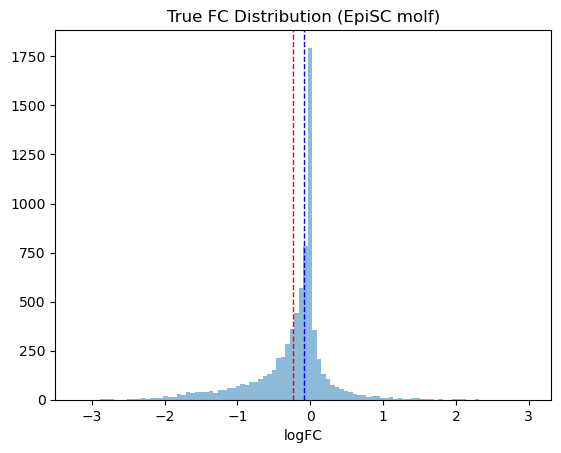

In [187]:
import matplotlib.pyplot as plt
# distribution of true and predicted log FC
plt.title(f"True FC Distribution ({ctype} {strain})")
plt.xlabel("logFC")
plt.hist(true_fc, bins=100, alpha=0.5)
plt.axvline(sum(true_fc) / len(true_fc), color = 'red', linestyle = 'dashed', \
            linewidth = 1, label = 'Mean')
plt.show()

## Plot Fold Change Distribution (by chromosome)

In [130]:
def load_h5py(path):
    merge_y = dict()
    if 'tmp' not in path:
        with h5py.File(path,'r') as f:
            for chrom in chroms:
                for c in chrom:
                    for allele in ['b6', str(strain)]:
                        merge_y[f'{c}_{allele}'] = f[f'{c}_{allele}'][()]
    else:
        with h5py.File(path, 'r') as f:
            for rep in tqdm(reps):
                for chrom in chroms:
                    for c in chrom:
                        for allele in ['b6', str(strain)]:
                            merge_y[f'{rep}_{c}_{allele}'] = f[f'{rep}_{c}_{allele}'][()]
    return merge_y

In [157]:
import os
# some utility functions
from utils import get_summits, get_shifts, one_hot, GCregress

N = []
for rep in reps:
    print(rep)
    bamfile = aligndir+b6_strain+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
    bamf = pysam.AlignmentFile(bamfile, "rb")
    N.append( sum([bamf.get_index_statistics()[i][1] for i in range(len(chrom_train+chrom_test+chrom_val))]) )
    bamf.close()

# process peakatlas file to get peaks dataframe
if ident[:3]=='_vi':     # This is us using a peak atlas, you would be using the else clause here
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += seqlen//2
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
    summits_neg = pd.read_csv(aligndir+'cd8_old/yi_cd8_uneg_peaks_33143.csv',sep=',',index_col=0)
    summits_neg['start'] += seqlen//2
    summits_neg = summits_neg.iloc[:,1:3].reset_index(drop=True)
    summits_neg.columns = range(2)
else:
    if ident=='_yi':
        peakfile = aligndir+'cd8_old/peaks_yi.bed'
    else:
        peakfile = aligndir+b6_strain+'/peaks/peakatlas.bed'
    peaks = pd.read_csv(peakfile, sep='\t', header=None)

    if not ident:
        # filter peaks based on IDR threshold (column 12 of BED)
        idr_thresh = 0.05
        idx = np.where( peaks.iloc[:,11] >= -np.log10(idr_thresh) )[0]
        peaks = peaks.loc[idx].reset_index(drop=True)

#     # remove blacklist regions - try with and without
#     blacklistfile = aligndir+'mm10-blacklist.v2.bed'
#     blacklist = pd.read_csv(blacklistfile, sep='\t', header=None)
#     peaks = remove_blacklist(peaks, blacklist)

    # get summits of called + flanking neg peaks (moving away from this to background unegs)
    summits, summits_neg = get_summits(peaks)
    
print("Done")

r1
r2
r3
Done


In [158]:
y = dict()
for rep in tqdm(reps):
    temp1 = pysam.AlignmentFile(datadir+'bam/'+rep+'_b6.bam', 'rb')
    temp2 = pysam.AlignmentFile(datadir+'bam/'+rep+f'_{strain}.bam', 'rb')
    temp3 = pysam.AlignmentFile(datadir+'bam/'+rep+'_both.bam', 'rb')

    for c_num in range(1, 20):
        y[f'{rep}_{c_num}_b6'] = []
        y[f'{rep}_{c_num}_{strain}'] = []

    for n,chrom in zip(name,chroms):
        print(rep, n, chrom)

        for c in chrom:        # for each chromosome in train/val/test set
            chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
            y_b6 = []
            y_strain = []
            for i in chromsummits:
                # for each summit peak, get the summed accessibility from BAM pileup
                y1 = temp1.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y2 = temp2.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y3 = temp3.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y_b6.append(y1+y3/2)
                y_strain.append(y2+y3/2)            

            y[f'{rep}_{c}_b6'] += y_b6
            y[f'{rep}_{c}_{strain}'] += y_strain
    
    temp1.close()
    temp2.close()
    temp3.close()
    
del y_b6, y_strain, y1, y2, y3, chromsummits

for key in y.keys():
    print(key)
    print(len(y[key]))

if save:
   with h5py.File(f'{datadir}acc_by_chrom_tmp.h5', 'w') as file:
       for key in y.keys():
           file.create_dataset(key, data = y[key]) 

  0%|          | 0/3 [00:00<?, ?it/s]

r1 train [1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
r1 val [3, 5]
r1 test [10, 15]
r2 train [1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
r2 val [3, 5]
r2 test [10, 15]
r3 train [1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
r3 val [3, 5]
r3 test [10, 15]
r1_1_b6
5487
r1_1_molf
5487
r1_2_b6
6132
r1_2_molf
6132
r1_3_b6
4206
r1_3_molf
4206
r1_4_b6
5055
r1_4_molf
5055
r1_5_b6
4873
r1_5_molf
4873
r1_6_b6
4276
r1_6_molf
4276
r1_7_b6
4834
r1_7_molf
4834
r1_8_b6
4048
r1_8_molf
4048
r1_9_b6
4349
r1_9_molf
4349
r1_10_b6
4069
r1_10_molf
4069
r1_11_b6
5291
r1_11_molf
5291
r1_12_b6
3275
r1_12_molf
3275
r1_13_b6
3601
r1_13_molf
3601
r1_14_b6
3120
r1_14_molf
3120
r1_15_b6
3462
r1_15_molf
3462
r1_16_b6
2694
r1_16_molf
2694
r1_17_b6
3428
r1_17_molf
3428
r1_18_b6
2593
r1_18_molf
2593
r1_19_b6
2290
r1_19_molf
2290
r2_1_b6
5487
r2_1_molf
5487
r2_2_b6
6132
r2_2_molf
6132
r2_3_b6
4206
r2_3_molf
4206
r2_4_b6
5055
r2_4_molf
5055
r2_5_b6
4873
r2_5_molf
4873
r2_6_b6
4276
r2_6_molf
427

In [118]:
y = load_h5py(f'{datadir}acc_by_chrom_tmp.h5')

print(y.keys())

print(y['r1_1_b6'])
print(y['r1_1_molf'])

  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['r1_1_b6', 'r1_1_molf', 'r1_2_b6', 'r1_2_molf', 'r1_4_b6', 'r1_4_molf', 'r1_6_b6', 'r1_6_molf', 'r1_7_b6', 'r1_7_molf', 'r1_8_b6', 'r1_8_molf', 'r1_9_b6', 'r1_9_molf', 'r1_11_b6', 'r1_11_molf', 'r1_12_b6', 'r1_12_molf', 'r1_13_b6', 'r1_13_molf', 'r1_14_b6', 'r1_14_molf', 'r1_16_b6', 'r1_16_molf', 'r1_17_b6', 'r1_17_molf', 'r1_18_b6', 'r1_18_molf', 'r1_19_b6', 'r1_19_molf', 'r1_3_b6', 'r1_3_molf', 'r1_5_b6', 'r1_5_molf', 'r1_10_b6', 'r1_10_molf', 'r1_15_b6', 'r1_15_molf', 'r2_1_b6', 'r2_1_molf', 'r2_2_b6', 'r2_2_molf', 'r2_4_b6', 'r2_4_molf', 'r2_6_b6', 'r2_6_molf', 'r2_7_b6', 'r2_7_molf', 'r2_8_b6', 'r2_8_molf', 'r2_9_b6', 'r2_9_molf', 'r2_11_b6', 'r2_11_molf', 'r2_12_b6', 'r2_12_molf', 'r2_13_b6', 'r2_13_molf', 'r2_14_b6', 'r2_14_molf', 'r2_16_b6', 'r2_16_molf', 'r2_17_b6', 'r2_17_molf', 'r2_18_b6', 'r2_18_molf', 'r2_19_b6', 'r2_19_molf', 'r2_3_b6', 'r2_3_molf', 'r2_5_b6', 'r2_5_molf', 'r2_10_b6', 'r2_10_molf', 'r2_15_b6', 'r2_15_molf', 'r3_1_b6', 'r3_1_molf', 'r3_2_b6', 'r

In [159]:
# merge RPMs across reps
merge_y = dict()

for chrom in chroms:
    for c in chrom:
        merge_y[f'{c}_b6'] = np.zeros_like(y[f'{rep}_{c}_b6'])
        merge_y[f'{c}_{strain}'] = np.zeros_like(y[f'{rep}_{c}_{strain}'])
        for i, rep in enumerate(reps):
            merge_y[f'{c}_b6'] += np.array(y[f'{rep}_{c}_b6']) * 1e6/N[i]
            merge_y[f'{c}_{strain}'] += np.array(y[f'{rep}_{c}_{strain}']) * 1e6/N[i]
        merge_y[f'{c}_b6'] = np.log2(1 + merge_y[f'{c}_b6'])
        merge_y[f'{c}_{strain}'] = np.log2(1 + merge_y[f'{c}_{strain}'])

if save:
   with h5py.File(f'{datadir}acc_by_chrom.h5', 'w') as file:
       for key in merge_y.keys():
           file.create_dataset(key, data = merge_y[key]) 

In [160]:
new_y = load_h5py(f'{datadir}acc_by_chrom.h5')

for key in new_y:
    print(key)
    print(new_y[key].shape)

print(new_y['1_b6'])
print(new_y['1_molf'])

1_b6
(5487,)
1_molf
(5487,)
2_b6
(6132,)
2_molf
(6132,)
4_b6
(5055,)
4_molf
(5055,)
6_b6
(4276,)
6_molf
(4276,)
7_b6
(4834,)
7_molf
(4834,)
8_b6
(4048,)
8_molf
(4048,)
9_b6
(4349,)
9_molf
(4349,)
11_b6
(5291,)
11_molf
(5291,)
12_b6
(3275,)
12_molf
(3275,)
13_b6
(3601,)
13_molf
(3601,)
14_b6
(3120,)
14_molf
(3120,)
16_b6
(2694,)
16_molf
(2694,)
17_b6
(3428,)
17_molf
(3428,)
18_b6
(2593,)
18_molf
(2593,)
19_b6
(2290,)
19_molf
(2290,)
3_b6
(4206,)
3_molf
(4206,)
5_b6
(4873,)
5_molf
(4873,)
10_b6
(4069,)
10_molf
(4069,)
15_b6
(3462,)
15_molf
(3462,)
[0.29443641 1.05039169 0.05128392 ... 0.42169218 4.08679561 0.21726692]
[0.29443641 1.05443595 0.05128392 ... 0.0335751  4.55730805 0.21726692]


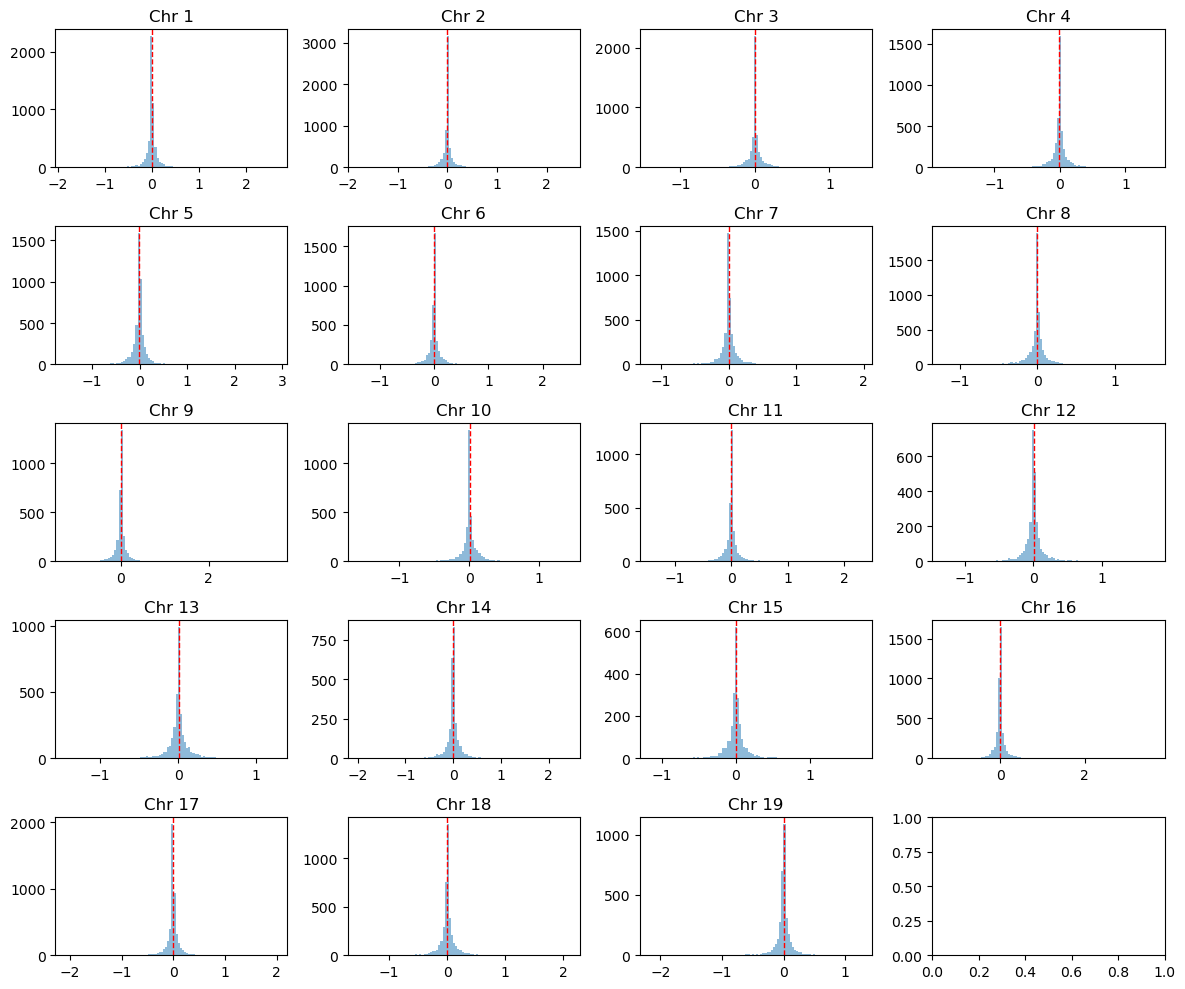

In [161]:
chrom_fc = []
for chrom in chroms:
    for c in chrom:
        c_fc = new_y[f'{c}_{strain}'] - new_y[f'{c}_b6']
        chrom_fc.append(c_fc)

fig, axes = plt.subplots(5, 4, figsize = (12, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < 19:
        ax.hist(chrom_fc[i], bins = 100, alpha = 0.5)
        ax.set_title(f'Chr {i+1}')
        ax.axvline(sum(chrom_fc[i]) / len(chrom_fc[i]), color = 'red', linestyle = 'dashed', \
                    linewidth = 1)
plt.tight_layout()
plt.show()

## Altering Unegs

In [90]:
# Start afresh, load your noGC data
x = dict()
y = dict()
with h5py.File(datadir+'data_trueuneg'+ident+'.h5','r') as f:
    for n in name:
        for allele in ['b6',f'{strain}']:
            x[n+'_'+allele] = f['x_'+n+'_'+allele][()]
            y[n+'_'+allele] = f['y_'+n+'_'+allele][()]
            if n!='test':
                x[n+'_'+allele+'_unegs'] = f['x_'+n+'_'+allele+'_unegs'][()]
        if n!='test':
            y[n+'_unegs'] = f['y_'+n+'_unegs'][()]

In [91]:
for key in y.keys():
    if "unegs" in key:
        y[key] = y[key] + 2

for key in y.keys():
    print(key, len(y[key]))
    print(y[key])

# Save everything to new file to be used by the model. A good sanity check is to see if your uneg data is the same
if save:
    with h5py.File(datadir+'data_trueuneg_v2'+ident+'.h5','w') as f:
        for key in x.keys():
            f.create_dataset('x_'+key, data=x[key])
        for key in y.keys():
            f.create_dataset('y_'+key, data=y[key])

train_b6 56102
[-0.82965797  0.79683787 -0.6566056  ... -0.00893866  2.11032971
  0.58042399]
train_spret 56102
[-1.17651612  0.80732373 -0.5704601  ... -0.02486328  3.73112724
  0.07782609]
train_unegs 56102
[-3. -3. -3. ... -3. -3. -3.]
val_b6 8343
[-0.58271579 -0.75152694 -0.38733944 ...  0.73122437 -1.24487128
 -0.82741466]
val_spret 8343
[-0.81998575 -0.93047291  0.34086629 ...  0.69129963 -1.14327668
 -0.75375347]
val_unegs 8343
[-3. -3. -3. ... -3. -3. -3.]
test_b6 6787
[-1.02987374  0.2564141   1.74452189 ... -0.94594688 -0.32558134
 -1.69546963]
test_spret 6787
[-0.88439968 -0.31646042  1.33169322 ... -1.00290007  0.57145193
 -1.6885764 ]


## Checking Peaks before Filtering

In [8]:
import pandas as pd
import numpy as np
from utils import get_summits

peak_path = f"{aligndir}/b6_{strain}/peaks/peakatlas.bed"

peak_df = pd.read_csv(peak_path, header = None, sep = "\t")
peak_df.head()

summits, summits_neg = get_summits(peak_df)

In [20]:
chrom_idx = np.where(summits[0] == 15)[0]
chrom_summits = summits.iloc[chrom_idx,]

print(np.where(chrom_summits[1] > 7116694)[0])
print(np.where(chrom_summits[1] < 7117194)[0])
loc_idx = list(set(np.where(chrom_summits[1] > 7115000)[0]).intersection(set(np.where(chrom_summits[1] < 7119000)[0])))
print(loc_idx)

print(chrom_summits.iloc[loc_idx])

[ 133  134  135 ... 6434 6435 6436]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132]
[132]
        0        1
49402  15  7115663


## Feature Attribution for alleleScan

In [29]:
# General import, names of train, test, val
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import os
import datetime
import re

basedir = '/data/leslie/sunge/'
aligndir = basedir+'f1_hybrid/EpiSC_ATAC_bam/'
ctype = 'EpiSC'
strain = 'cast'

datadir = f'{basedir}f1_ASA/{strain}/{ctype}/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']
seqlen = 300

save = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
modelname = 'm3'
dataset = 'both'
use_prior = '1'
batchsize = '16'
gc = ''
ident = ''
weight = 1.0
model_disc = '2.2.1'
fc_head = '' #'_fc' for fc_head

figdir = f'{basedir}f1_ASA/figs/{modelname}_{dataset}_{use_prior}_{batchsize}_{str(weight)}_{model_disc}{fc_head}/{ctype}/{strain}'
print(figdir)
if not os.path.exists(figdir):
    os.makedirs(figdir)

/data/leslie/sunge/f1_ASA/figs/m3_both_1_16_1.0_2.2.1/EpiSC/cast


In [31]:
from utils import unhot
flag = True    # True for specific peak, False for entire test set

if ident[:3]=='_vi':
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += 150
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
else:
    summits = pd.read_csv(f'{basedir}f1_ASA/{strain}/{ctype}/data/summits{ident}.csv', header=None)
print(len(summits))

81905


In [32]:
import torch
# from run import load_data
from run import load_data
from model import alleleScan
from utils import trim_weights_dict
from captum.attr import IntegratedGradients
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
method = 'IG'

SAVEPATH = f"{basedir}f1_ASA/{strain}/{ctype}/ckpt_models/{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}_{str(weight)}_{model_disc}{fc_head}.hdf5"
print(SAVEPATH)
weights = torch.load(SAVEPATH)   # get the weights
model = alleleScan(2, 0.2)    # uncomment for noFC
# transfer only the relevant weights to the new model
print("Passed transfer weights")
model.load_state_dict(weights)
# supermodel = pairScanWrapper(model)
supermodel = model
if method=='IG':
    ig = IntegratedGradients(supermodel)
    supermodel.to(DEVICE)
supermodel.eval()

if flag:
    # code in case the locus is out of test set
    # finding a particular summit 12:4065636-4065785
    seq_name = '6:122715936-122716242'.split(':') #NANOG
    # seq_name = '15:7116694-7117194'.split(':') #LIFr
    # seq_name = '15:7082062-7132918'.split(':')
    # seq_name = '15:716944'
    c = int(seq_name[0])
    lims = [int(k) for k in seq_name[1].split('-')]
    print(c, lims)
    if len(lims)>1: # left and right limits given
        temp = summits.iloc[np.where(summits[0]==c)[0],:]
        print(list(set(np.where(temp[1]>lims[0])[0]).intersection(set(np.where(temp[1]<lims[1])[0])) ))
        print(temp.iloc[list(set(np.where(temp[1]>lims[0])[0]).intersection(set(np.where(temp[1]<lims[1])[0])) )])
        temp = temp.iloc[list(set(np.where(temp[1]>lims[0])[0]).intersection(set(np.where(temp[1]<lims[1])[0])) )[0], 1]
        print(temp)
    else:           # summit location given
        temp = lims[0]
    # find dataset with chromosome c
    i = [i for i in range(len(chroms)) if c in chroms[i]][0]
    print(f'found in {name[i]}..')
    x,y = [item for j,item in enumerate(load_data(ctype,'both',gc+ident,strain, get_rc=False,frac=0.)) if (j==i or j==i+3)]
    print(x.shape)
    x = x.reshape(-1, x.shape[-2], x.shape[-1])
    y = y.reshape(-1)
    
    # accumulate peak numbers in order to get index in x of particular summit
    idx = 0
    for chrom in chroms[i]:
        if chrom != c:
            idx += len(np.where(summits[0]==chrom)[0])
        else:
            chromsummits = summits.iloc[np.where(summits[0]==chrom)[0],:]
            idx += np.where(chromsummits[1]==temp)[0][0]
            break

    print(idx)
    
    x = x[[idx*2,idx*2+1]]    # (2,300,4)
    y = y[[idx*2,idx*2+1]]    # (2,)
    print(x.shape)
    print(y.shape)
    print(y[1]-y[0])
    x_dna = unhot(x)
    x = np.expand_dims(x, axis=0)  # (1,2,300,4)

else:  # for test set
    _,_,x,_,_,y = load_data(ctype, 'both', gc+ident, get_rc=False, frac=0.)
    y = y.reshape(-1)
    x_dna = unhot(x.reshape(-1, x.shape[-2], x.shape[-1]))

    chromsummits = []
    for i in chrom_test:
        chromsummits.append(np.array(summits.loc[np.where(summits[0]==i)[0],1]))
    chromsummits = np.concatenate(chromsummits)

print(x.shape)

# x: one-hot encoded 300bp sequence inputs with shape (n, 2, 300, 4)
if method=='IG':
    attr = []
    for i in tqdm( range(0, len(x), int(batchsize)) ):
        test_input_tensor = torch.from_numpy(x[i:i+int(batchsize)]).type(torch.FloatTensor).transpose(2,3).to(DEVICE)
        test_input_tensor = test_input_tensor.view(-1, x.shape[-1], x.shape[-2])
        test_input_tensor.requires_grad_()
        attr.append(ig.attribute(test_input_tensor).detach().cpu().numpy())
    attr = np.concatenate(attr)
elif method=='SH':
    import shap
    import h5py
    with h5py.File(datadir+'data_vi_150bp.h5','r') as f:
        background = f['x_train_b6_unegs'][()]
        background = background[np.random.choice(np.arange(len(background)), size = 100, replace=False)]
    sh = shap.DeepExplainer(supermodel, torch.tensor(background.transpose(0,2,1), dtype=torch.float32))
    attr = sh.shap_values(torch.tensor(np.squeeze(x).transpose(0,2,1), dtype = torch.float32))

attr = attr.reshape(-1,2,attr.shape[-2],attr.shape[-1])   # get in same shape as x

/data/leslie/sunge/f1_ASA/cast/EpiSC/ckpt_models/m3_both_1_16_1.0_2.2.1.hdf5
Passed transfer weights
6 [122715936, 122716242]
[3507]
       0          1
66811  6  122716098
122716098
found in train..
(64283, 2, 300, 4)
21300
(2, 300, 4)
(2,)
-0.08732405166737722
(1, 2, 300, 4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
def get_highlight_idx(lims, snp_idx_lst):
    highlight_dict = {"red" : []}
    highlight_inds = []
    for idx in snp_idx_lst:
        diff = idx - lims[0]
        highlight_inds.append(diff)
        highlight_dict["red"].append((max(0, diff - 10), min(diff + 10, lims[1]-lims[0])))
    print(highlight_dict)
    print(highlight_inds)
    return highlight_dict, highlight_inds

def plot_snp_region(score, peak_range):
    score_sub = score[peak_range[0]:peak_range[1], :]
    viz_sequence.plot_weights(score_sub, subticks_frequency=2, figsize = (5,1)) 

chr6: 122715948-122716248
True Log2fc (cast/b6): -0.08732405166737722
{'red': [(0, 18), (212, 232)]}
[8, 222]
b6       IG


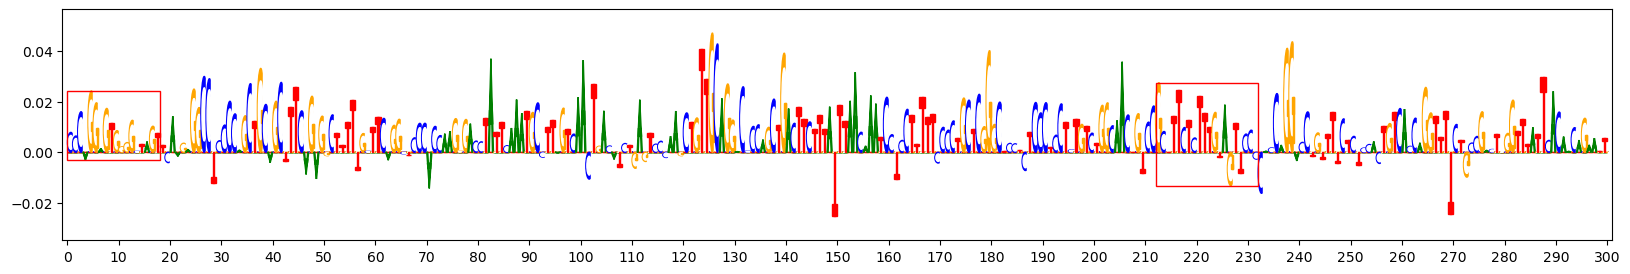

cast     IG


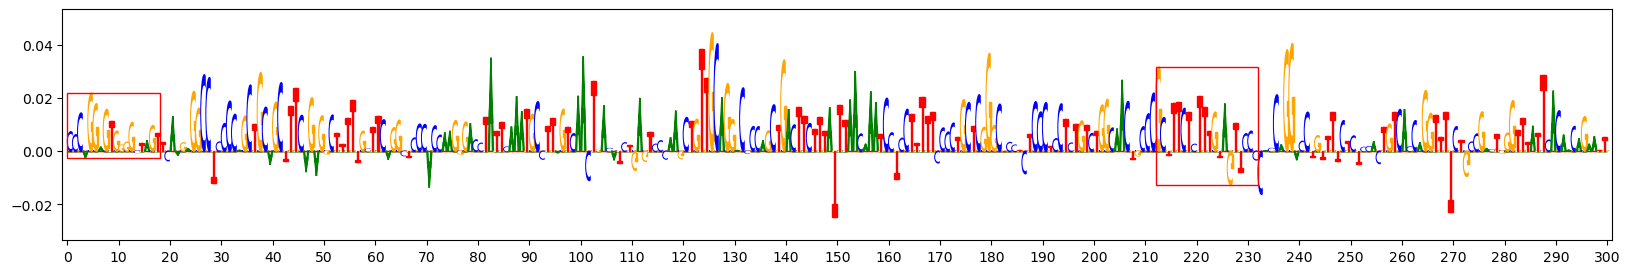

In [33]:
import deeplift
from deeplift.visualization import viz_sequence
import matplotlib.patches

if flag:
    i=0
    print(f'chr{c}: {temp-seqlen//2}-{temp+seqlen//2}')
    print(f'True Log2fc ({strain}/b6):', y[1]-y[0])
    # snp_idx, to be replaced with code to find SNP locations
    idx = [122715944, 122716158] #EpiSC cast
    # idx = [122716126] #EpiSC molf, pwk
    # idx = [122715944, 122716001, 122716034, 122716126, 122716158, 122716162] #EpiSC spret all
    # idx = [122715944, 122716034, 122716126] #EpiSC spret filtered
    
    
    highlight_dict, _ = get_highlight_idx(lims, idx)
#     idx = [76, 104, 135, 234, 245] #18:80598316-80598465
#     idx = [114, 121, 182] #17:56958140-56958289
#     idx = [133, 138] #10:88540328
#     idx = [58, 123, 128, 178, 226] #10:118954176
#     idx = None
else:
    rank = 20       # fold change rank of true accessibility change
    i = np.where(np.abs(true_fc)==temp[rank-1])[0][0]
    if i>=len( np.array(summits.loc[np.where(summits[0]==chrom_test[0])[0],1]) ):
        c = chrom_test[1]
    else:
        c = chrom_test[0]
    
    # get locations of SNPs and indels
    idx = get_loci(mods, c, chromsummits[i])

    print(f'chr{c}: {chromsummits[i]-seqlen//2}-{chromsummits[i]+seqlen//2}')
    print('SNP/Indel location:', idx)
    print(f'True Log2fc ({strain}/b6):', true_fc[i])

seq_b6 = x_dna[i]
seq_ca = x_dna[len(x_dna)//2+i]

ylims = [-0.6,0.9]
scores = x[i]*attr[i].transpose((0,2,1))   # (2,300,4) scores for b6,ca
print('b6      ', method)
viz_sequence.plot_weights(scores[0], subticks_frequency=10, figsize = (20,3), highlight=highlight_dict)#, ylims=ylims)
# for p in highlight_dict["red"]:
#     plot_snp_region(scores[0], p)
# viz_sequence.plot_weights(scores[0], subticks_frequency=10, figsize = (20,3))#, ylims=ylims)
print(f'{strain}    ', method)
viz_sequence.plot_weights(scores[1], subticks_frequency=10, figsize = (20,3), highlight=highlight_dict)#, ylims=ylims)
# for p in highlight_dict["red"]:
#     plot_snp_region(scores[1], p)
# viz_sequence.plot_weights(scores[1], subticks_frequency=10, figsize = (20,3))#, ylims=ylims)

## Other path tests

In [1]:
import os
import numpy as numpy
import h5py
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from model import pairScan, place_tensor, fourier_att_prior_loss, fc_loss

basedir = "/data/leslie/sunge/f1_ASA"
celltype = "iPSC"
strain = "cast"

filename = "ad_both_1_16_1.0_2.2.1_fc.hdf5"
filepath = f"{basedir}/{strain}/{celltype}/ckpt_models/{filename}"

In [57]:
model.load_state_dict(torch.load(SAVEPATH))

/data/leslie/sunge/f1_ASA/cast/iPSC/ckpt_models/ad_both_1_16_1.0_2.2.1_fc.hdf5


OSError: Unable to synchronously open file (file signature not found)